In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import animation
import imageio.v2 as imageio

In [2]:
def getProb(vec):
    vec = vec - (vec.max()/2)
    if vec.max() > 500:
        vec = vec / (vec.max() / 500)
    math = np.exp(vec)/np.sum(np.exp(vec))
    return np.array(list(map(float, math)))

In [3]:
class Sender:
        
    def __init__(self, inputs_n: int, messages_n_m: (int, int), eps: float = 1e-6):
        self.messages = messages_n_m
        self.message_weights = (np.zeros((inputs_n, messages_n_m[0])), np.zeros((inputs_n, messages_n_m[1])))
        self.message_weights[0].fill(eps)
        self.message_weights[1].fill(eps)
        self.channel_weights = np.zeros(2)
        self.channel_weights.fill(eps)
        self.last_situation = (0, 0, (0, 0)) # urn, input, message, 
        
    def send_message(self, input: int) -> (int, int):
        # get a channel to manipulate
        channel_probs = getProb(self.channel_weights)
        channel = np.random.choice([0, 1], p=channel_probs)
        
        if channel == 0:
            # manipulate channel 0, the other is picked at random
            probs = getProb(self.message_weights[0][input, :])
            message = (np.random.choice(self.messages[0], p=probs), np.random.choice(self.messages[1]))
        else:
            # manipulate channel 0, the other is picked at random
            probs = getProb(self.message_weights[1][input, :])
            message = (np.random.choice(self.messages[0]), np.random.choice(self.messages[1], p=probs))
       
        self.last_situation = (channel, input, message)
        return message

    def learn_from_feedback(self, reward: float, channelReward :float) -> None:
        last_channel = self.last_situation[0]
        self.channel_weights[last_channel] += channelReward
        self.message_weights[last_channel][(self.last_situation[1], self.last_situation[2][last_channel])] += reward


In [4]:
class Receiver:
        
    def __init__(self, n_messages: int, m_messages: int, n_actions: int, eps: float = 1e-6):
        self.n_actions = n_actions
        self.action_weights = (np.ndarray((n_messages, n_actions)), np.ndarray((m_messages, n_actions)))
        self.channel_weights  = np.zeros(2)
        self.action_weights[0].fill(eps)
        self.action_weights[1].fill(eps)
        self.channel_weights.fill(eps)
        self.last_situation = (0, (0, 0), 0)
        
    def act(self, message: (int, int)) -> int:
        # get channel to pay attention to
        channel_probs = getProb(self.channel_weights)
        channel = np.random.choice([0, 1], p=channel_probs)

        # pick action from focused channel
        probs = getProb(self.action_weights[channel][message[channel], :])
        action = np.random.choice(self.n_actions, p=probs)
            
        self.last_situation = (channel, message, action)
        return action

    def learn_from_feedback(self, reward: float, channelReward: float) -> None:
        last_channel = self.last_situation[0]
        self.channel_weights[last_channel] += channelReward  
        self.action_weights[last_channel][(self.last_situation[1][last_channel], self.last_situation[2])] += reward

In [5]:
class World:
    def __init__(self, n_states: int, seed: int = 1701):
        self.n_states = n_states
        self.state = 0
        self.rng = np.random.RandomState(seed)
        
    def emit_state(self) -> int:
        self.state = self.rng.randint(self.n_states)
        return self.state
    
    def evaluate_action(self, action: int) -> float:
        return 1 if action == self.state else 0

In [6]:
class Run:
    def __init__(self, log_fitness = False):
        self.generations = 4000
        self.enableChannelLearning = 0
        self.sender_convergence = []
        self.receiver_convergence = []
        self.fitness_convergence = []
        self.log_fitness = log_fitness
        self.num_inputs = 5
        self.channel_0 = 5
        self.channel_1 = 4
        self.sender = Sender(self.num_inputs, (self.channel_0, self.channel_1))
        self.receiver = Receiver(self.channel_0, self.channel_1, self.num_inputs)
        self.world = World(self.num_inputs)
        
    def simulate(self):
        for epoch in range(self.generations):
            world_state = self.world.emit_state()
            message = self.sender.send_message(world_state)
            action = self.receiver.act(message)
            reward = self.world.evaluate_action(action)
            channelReward = 0 if epoch < self.enableChannelLearning else reward/30
            self.receiver.learn_from_feedback(reward, channelReward)
            self.sender.learn_from_feedback(reward, channelReward)
            if self.log_fitness:
                sw = getProb(self.sender.channel_weights)
                rw = getProb(self.receiver.channel_weights)
                ft = self.get_fitness()
                self.sender_convergence.append(sw[0])
                self.receiver_convergence.append(rw[0])
                self.fitness_convergence.append(ft)

    def get_channel_fitness(self, channel):
        return (np.apply_along_axis(getProb, 1, self.sender.message_weights[channel]) * np.apply_along_axis(getProb, 1, self.receiver.action_weights[channel]).T).sum() / self.num_inputs

    def get_fitness(self):
        s_channel_prob = getProb(self.sender.channel_weights)
        r_channel_prob = getProb(self.receiver.channel_weights)
        channel_0_fitness = self.get_channel_fitness(0)
        channel_1_fitness = self.get_channel_fitness(1)
        return s_channel_prob[0] * r_channel_prob[0] * channel_0_fitness + s_channel_prob[1] * r_channel_prob[1] * channel_1_fitness
    
    def both_heatmaps(self):
        for channel in range(2):
            self.heatmap(self.receiver.action_weights[channel], 'messages', 'actions', f'Receiver\'s weights on channel {channel}, rollout')
            self.heatmap(self.sender.message_weights[channel], 'inputs', 'messages', f'Sender\'s weights on channel {channel}, rollout')

    def heatmap(self, mat, xtitle, ytitle, title):
        if mat.max() > 500:
            mat = mat / (mat.max(axis=0) / 500)
        plt.tight_layout(pad=0)
        plot = sns.heatmap(
            (np.exp(mat).T/np.exp(mat).sum(axis=1)), 
            square=True, cbar=False, annot=True, fmt='.1f'
        ).get_figure()
        plt.xlabel(xtitle)
        plt.ylabel(ytitle)
        plt.title(title)
        plt.show()
        plt.clf()
    
    def plot(self, series, title):
        t = np.arange(0, self.generations)
        fig, axs = plt.subplots(1, 1, layout='constrained')
        axs.plot(t, series)
        axs.set_ylim(0, 1)
        axs.set_xlabel('Generations')
        axs.set_ylabel(title)
        axs.grid(True)
        plt.show()
        

channel 0 fitness 0.5024187110339703
channel 1 fitness 0.8
fitness 0.8


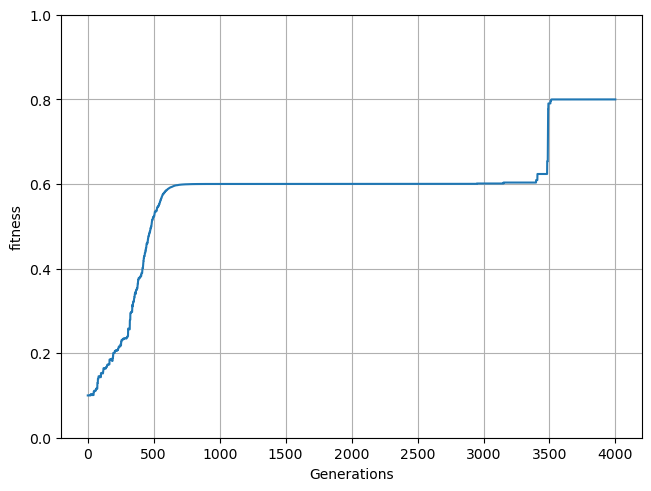

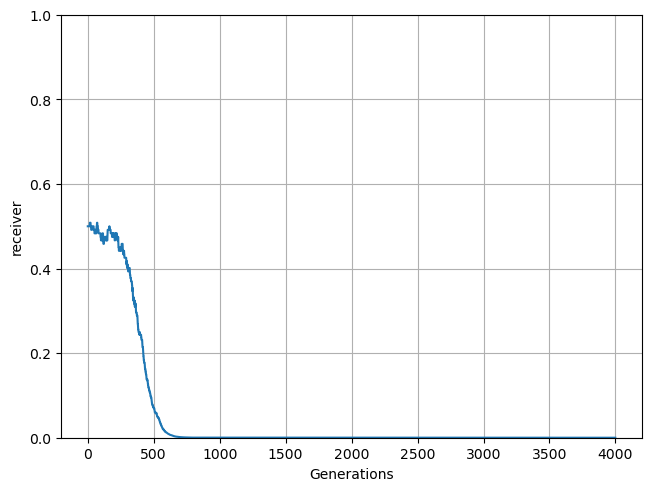

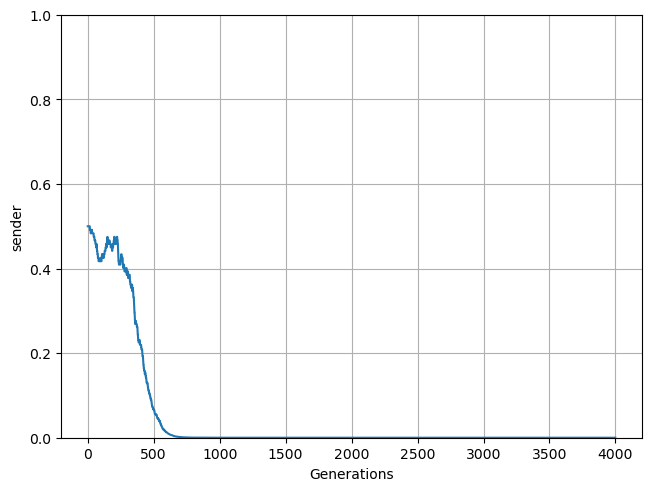

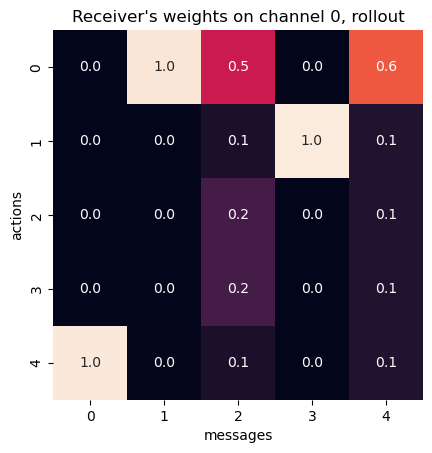

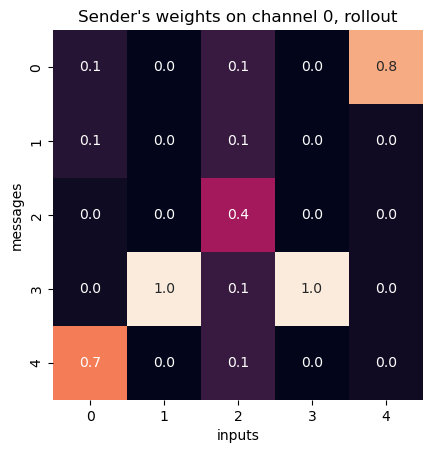

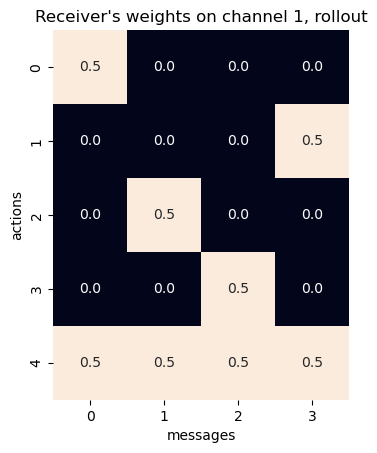

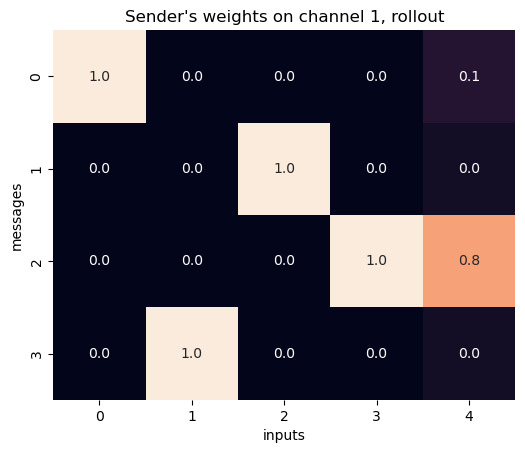

<Figure size 640x480 with 0 Axes>

In [12]:
run = Run(log_fitness = True)
run.simulate()

print("channel 0 fitness", run.get_channel_fitness(0))
print("channel 1 fitness", run.get_channel_fitness(1))
print("fitness", run.get_fitness())

run.plot(run.fitness_convergence, "fitness")
run.plot(run.receiver_convergence, "receiver")
run.plot(run.sender_convergence, "sender")
run.both_heatmaps()

In [8]:
sender_optimum  = 0
receiver_optimum = 0 
converge = 0
for i in range(100):
    if i % 10 == 0:
        print(i)
    run = Run()
    run.simulate()
    #run.plot()
    run.sender.channel_weights[0] > run.sender.channel_weights[1]
    is_sender_optimum = run.sender.channel_weights[0] > run.sender.channel_weights[1]
    is_receiver_optimum = run.receiver.channel_weights[0] > run.receiver.channel_weights[1]
    if is_sender_optimum:
        sender_optimum += 1
    if is_receiver_optimum:
        receiver_optimum += 1
    if (is_sender_optimum and is_receiver_optimum) or ((not is_sender_optimum) and (not is_receiver_optimum)):
        converge += 1
        
print("sender ends up in optimum", sender_optimum)
print("receiver ends up in optimum", receiver_optimum)
print("both converge", converge)

0
10
20
30
40
50
60
70
80
90
sender ends up in optimum 48
receiver ends up in optimum 48
both converge 100


In [13]:
run.receiver.action_weights[1]

array([[7.10000001e+02, 1.00000000e-06, 1.00000000e-06, 2.00000100e+00,
        1.00000000e-06],
       [1.00000000e-06, 8.00000100e+00, 1.26000001e+02, 1.00000000e-06,
        1.00000000e-06],
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 7.08000001e+02,
        1.00000000e-06],
       [1.00000000e-06, 7.24000001e+02, 1.00000000e-06, 1.00000000e-06,
        1.00000000e-06]])

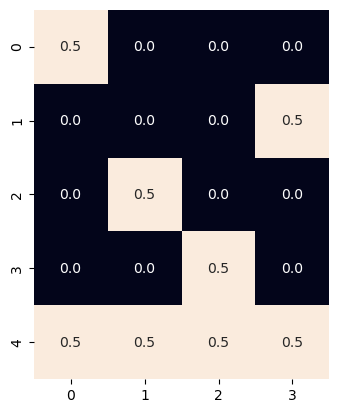

<Figure size 640x480 with 0 Axes>

In [14]:
run.heatmap(run.receiver.action_weights[1], "", "", "")

In [18]:
a = run.receiver.action_weights[1]
a.max()
a

array([[7.10000001e+02, 1.00000000e-06, 1.00000000e-06, 2.00000100e+00,
        1.00000000e-06],
       [1.00000000e-06, 8.00000100e+00, 1.26000001e+02, 1.00000000e-06,
        1.00000000e-06],
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 7.08000001e+02,
        1.00000000e-06],
       [1.00000000e-06, 7.24000001e+02, 1.00000000e-06, 1.00000000e-06,
        1.00000000e-06]])

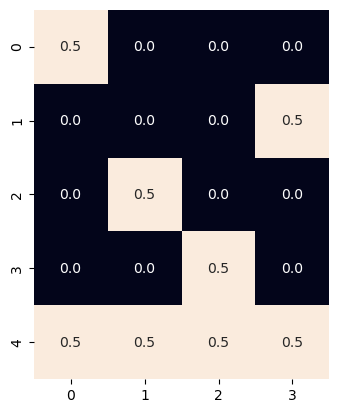

<Figure size 640x480 with 0 Axes>

In [28]:
run.heatmap(a / (a.max() / 500), "", "", "")